In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Data

In [95]:
data = pd.read_csv('data/heart.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  306 non-null    int64  
 1   Age         306 non-null    int64  
 2   Sex         306 non-null    int64  
 3   ChestPain   306 non-null    object 
 4   RestBP      306 non-null    int64  
 5   Chol        306 non-null    int64  
 6   Fbs         306 non-null    int64  
 7   RestECG     306 non-null    int64  
 8   MaxHR       306 non-null    int64  
 9   ExAng       306 non-null    int64  
 10  Oldpeak     306 non-null    float64
 11  Slope       306 non-null    int64  
 12  Ca          302 non-null    float64
 13  Thal        304 non-null    object 
 14  AHD         306 non-null    object 
dtypes: float64(2), int64(10), object(3)
memory usage: 36.0+ KB


## Data Processing

In [96]:
data.dropna(inplace = True)

In [97]:
def outlier(table, column: str):
    column_z = column + 'Z'
    table[column_z] = (table[column] - table[column].mean()) / table[column].std()

    index = data[ data[column_z] > 4].index
    data.drop(index, inplace = True)
    index = data[ data[column_z] < -4].index
    data.drop(index, inplace = True)

    data.drop(columns = column_z, inplace = True)
    return

In [98]:
outlier(data, 'Age')
outlier(data, 'Oldpeak')
outlier(data, 'MaxHR')
outlier(data, 'RestBP')
outlier(data, 'Chol')
data.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


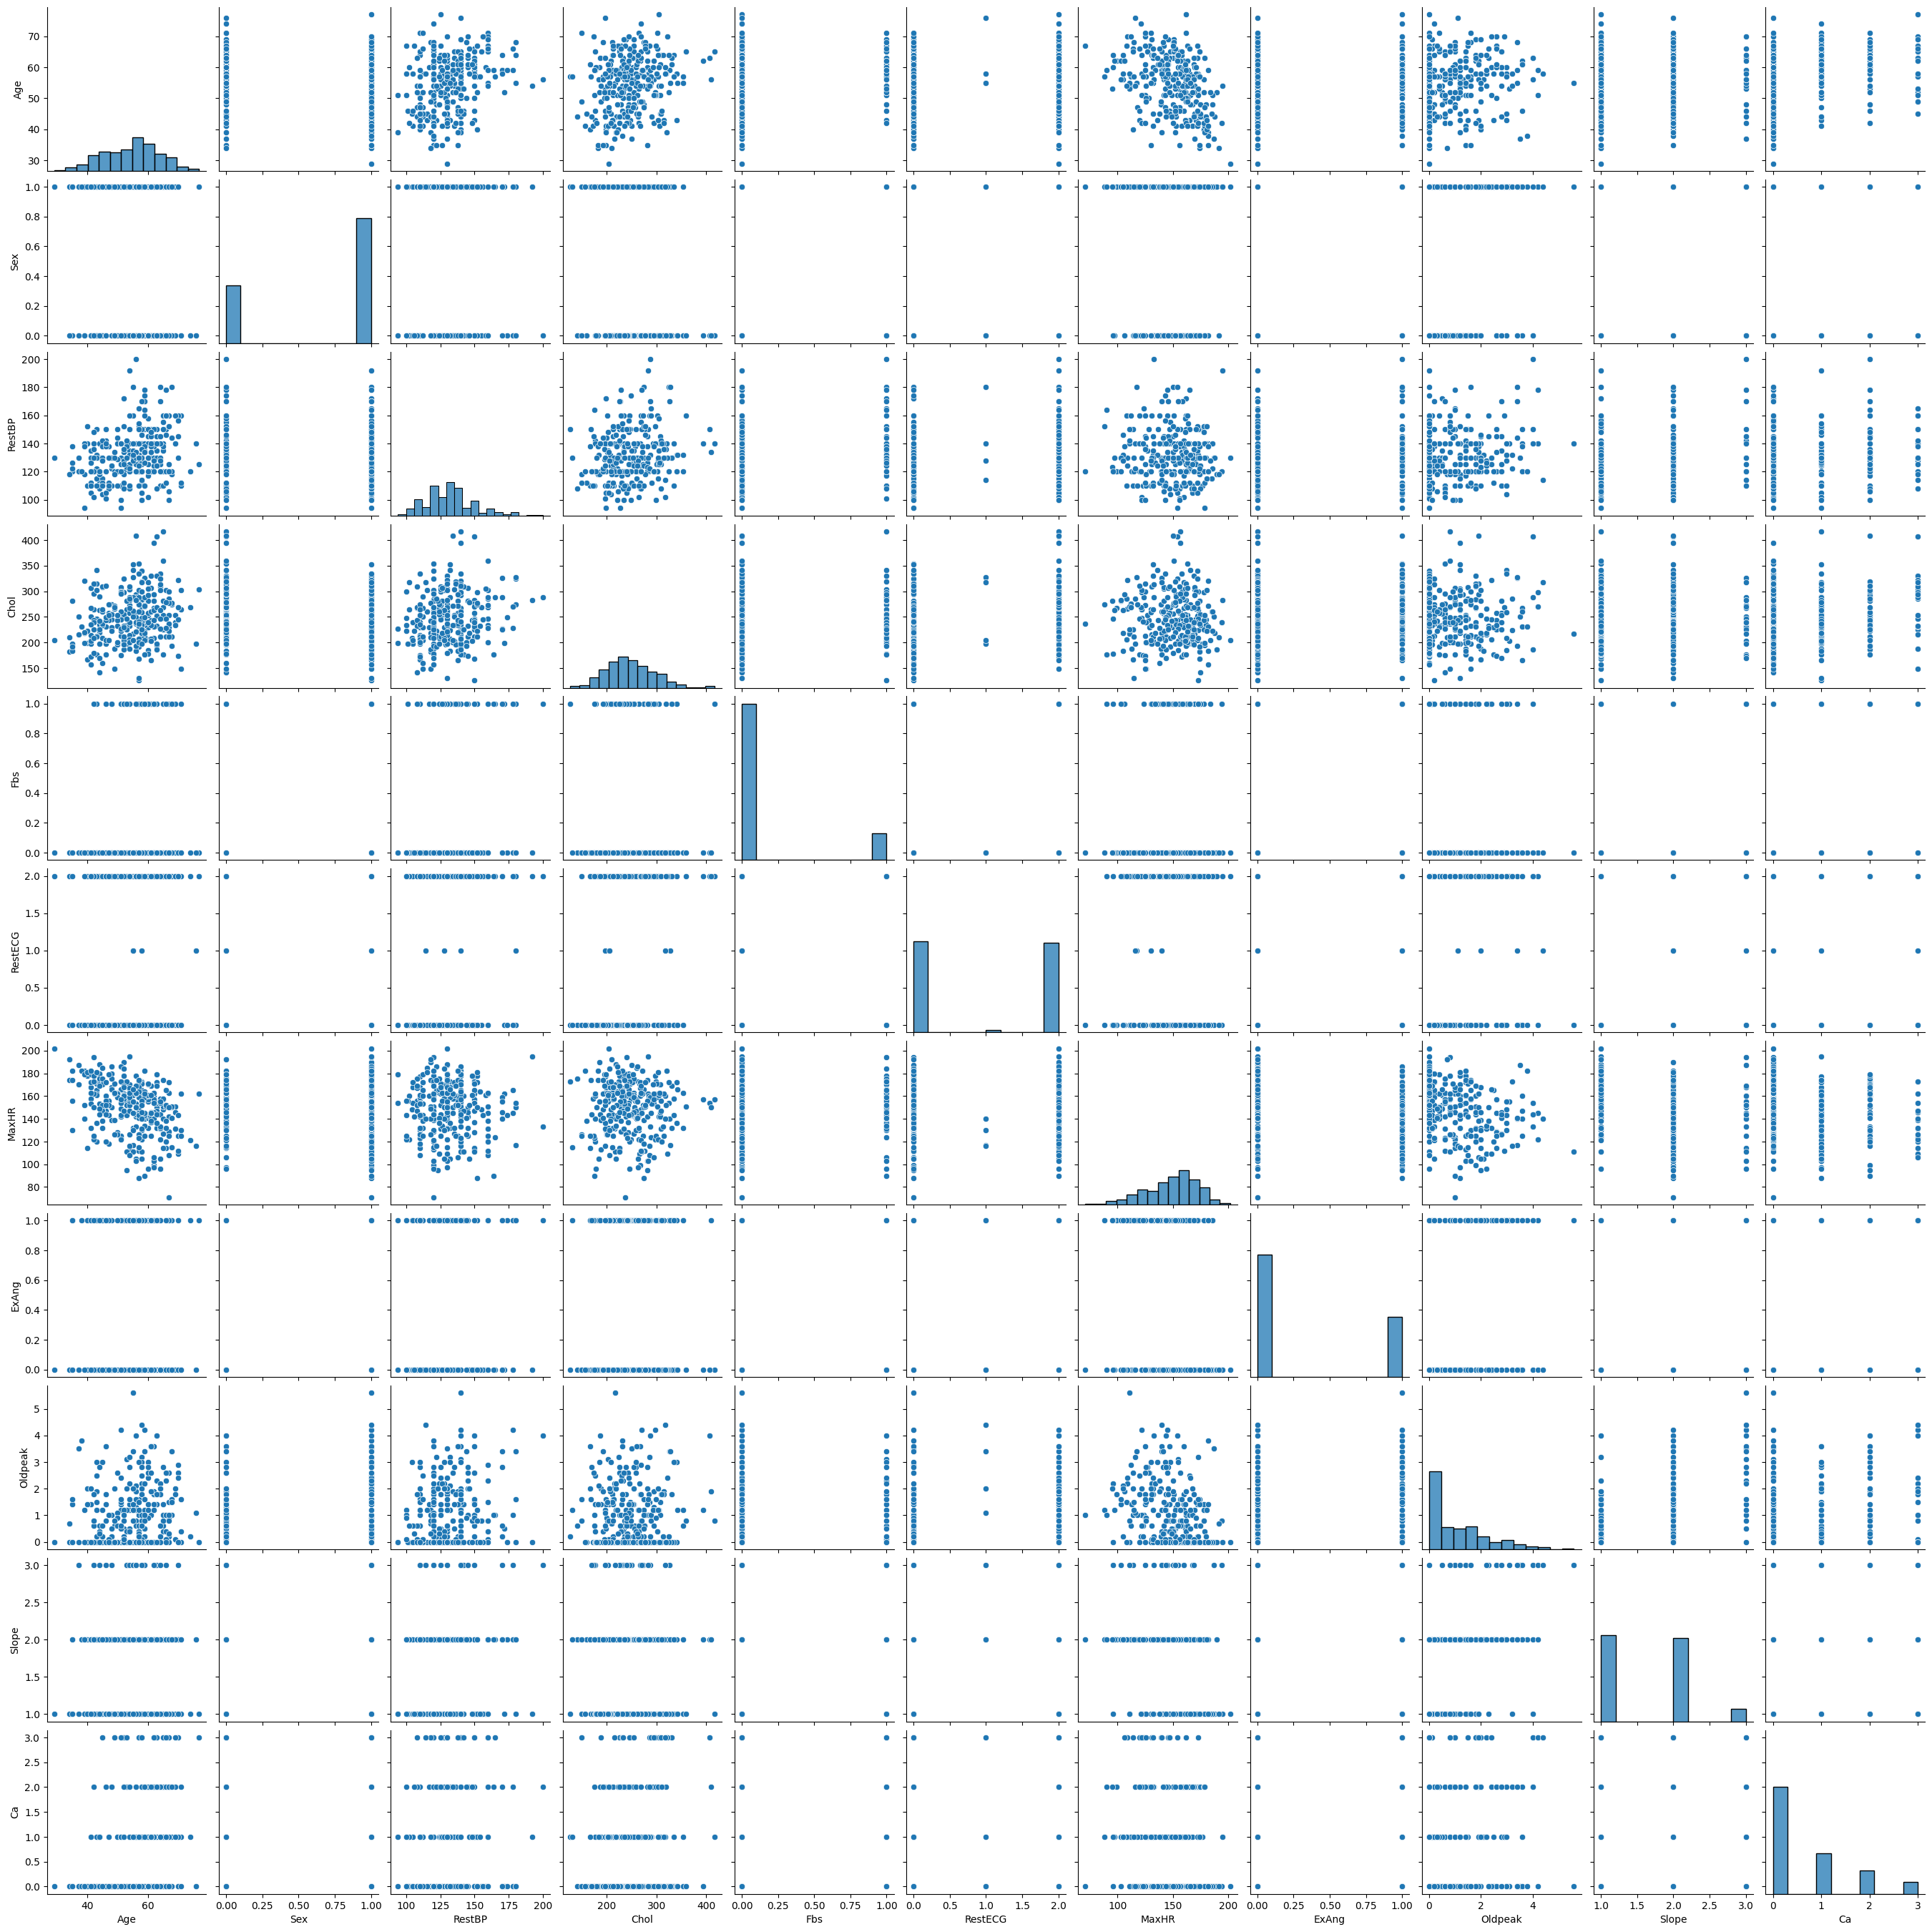

In [99]:
plt.rcParams['figure.figsize'] = (15, 15)
sns.pairplot(data.drop(columns='Unnamed: 0'))

In [100]:
data['Age'] = (data['Age'] - data['Age'].min()) / (data['Age'].max() - data['Age'].min())
data['RestBP'] = (data['RestBP'] - data['RestBP'].min()) / (data['RestBP'].max() - data['RestBP'].min())
data['Chol'] = (data['Chol'] - data['Chol'].min()) / (data['Chol'].max() - data['Chol'].min())
data['MaxHR'] = (data['MaxHR'] - data['MaxHR'].min()) / (data['MaxHR'].max() - data['MaxHR'].min())

data.describe()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,151.289116,0.531037,0.683673,0.355603,0.414615,0.146259,0.993197,0.599626,0.329932,1.034354,1.595238,0.673469
std,87.396988,0.188589,0.465835,0.167329,0.167022,0.353968,0.994844,0.175907,0.470990,1.131798,0.615037,0.932268
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,75.250000,0.395833,0.000000,0.245283,0.292955,0.000000,0.000000,0.473282,0.000000,0.000000,1.000000,0.000000
50%,150.500000,0.562500,1.000000,0.339623,0.402062,0.000000,1.000000,0.622137,0.000000,0.800000,2.000000,0.000000
75%,226.750000,0.666667,1.000000,0.433962,0.514605,0.000000,2.000000,0.725191,1.000000,1.600000,2.000000,1.000000
max,302.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,5.600000,3.000000,3.000000


In [101]:
AHD_dict = {AHD:i for i,AHD in enumerate(data['AHD'].unique())}

def encode_ahd(AHD):
  return AHD_dict[AHD]

data['AHD'] = data['AHD'].apply(encode_ahd)

In [102]:
Thal_dict = {Thal:i for i,Thal in enumerate(data['Thal'].unique())}

def encode_Thal(Thal):
  return Thal_dict[Thal]

data['Thal'] = data['Thal'].apply(encode_Thal)
data = pd.concat([data, pd.get_dummies(data['Thal'], prefix = 'Thal')], axis = 1)
data.drop('Thal', axis = 1, inplace = True)

data.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,Thal_0,Thal_1,Thal_2
0,1,0.708333,1,typical,0.481132,0.367698,1,2,0.603053,0,2.3,3,0.0,0,True,False,False
1,2,0.791667,1,asymptomatic,0.622642,0.549828,0,2,0.282443,1,1.5,2,3.0,1,False,True,False
2,3,0.791667,1,asymptomatic,0.245283,0.353952,0,2,0.442748,1,2.6,2,2.0,1,False,False,True
3,4,0.166667,1,nonanginal,0.339623,0.426117,0,0,0.885496,0,3.5,3,0.0,0,False,True,False
4,5,0.250000,0,nontypical,0.339623,0.268041,0,2,0.770992,0,1.4,1,0.0,0,False,True,False


In [103]:
Pain_dict = {ChestPain:i for i,ChestPain in enumerate(data['ChestPain'].unique())}

def encode_ChestPain(ChestPain):
  return Pain_dict[ChestPain]

data['ChestPain'] = data['ChestPain'].apply(encode_ChestPain)
data = pd.concat([data, pd.get_dummies(data['ChestPain'], prefix = 'ChestPain')], axis = 1)

data.drop('ChestPain', axis = 1, inplace = True)

data.head()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,Thal_0,Thal_1,Thal_2,ChestPain_0,ChestPain_1,ChestPain_2,ChestPain_3
0,1,0.708333,1,0.481132,0.367698,1,2,0.603053,0,2.3,3,0.0,0,True,False,False,True,False,False,False
1,2,0.791667,1,0.622642,0.549828,0,2,0.282443,1,1.5,2,3.0,1,False,True,False,False,True,False,False
2,3,0.791667,1,0.245283,0.353952,0,2,0.442748,1,2.6,2,2.0,1,False,False,True,False,True,False,False
3,4,0.166667,1,0.339623,0.426117,0,0,0.885496,0,3.5,3,0.0,0,False,True,False,False,False,True,False
4,5,0.250000,0,0.339623,0.268041,0,2,0.770992,0,1.4,1,0.0,0,False,True,False,False,False,False,True


In [104]:
y = data['AHD']
data.drop('AHD', axis = 1, inplace = True)
data.shape

data = data.to_numpy().astype('float32')
y = y.to_numpy().astype('float32')

## Model Construction

In [105]:
input_layer = layers.Input(shape = (None, 19))
x = layers.Dense(100, activation = 'relu')(input_layer)
x = layers.Dense(100, activation = 'relu')(input_layer)
x = layers.Dense(100, activation = 'relu')(input_layer)
x = layers.Dense(1)(x)
model = Model(input_layer, x)

In [106]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

In [107]:
hist = model.fit(data, y, epochs=40, batch_size=10, validation_split=0.2)

Epoch 1/40
24/24 [==============================] - 1s 8ms/step - loss: 6.8920 - accuracy: 0.5532 - val_loss: 8.1046 - val_accuracy: 0.4746
Epoch 2/40
24/24 [==============================] - 0s 2ms/step - loss: 6.8920 - accuracy: 0.5532 - val_loss: 8.1046 - val_accuracy: 0.4746
Epoch 3/40
24/24 [==============================] - 0s 2ms/step - loss: 6.8920 - accuracy: 0.5532 - val_loss: 8.1046 - val_accuracy: 0.4746
Epoch 4/40
24/24 [==============================] - 0s 2ms/step - loss: 6.8920 - accuracy: 0.5532 - val_loss: 8.1046 - val_accuracy: 0.4746
Epoch 5/40
24/24 [==============================] - 0s 2ms/step - loss: 6.8920 - accuracy: 0.5532 - val_loss: 8.1046 - val_accuracy: 0.4746
Epoch 6/40
24/24 [==============================] - 0s 2ms/step - loss: 6.8920 - accuracy: 0.5532 - val_loss: 8.1046 - val_accuracy: 0.4746
Epoch 7/40
24/24 [==============================] - 0s 2ms/step - loss: 6.8920 - accuracy: 0.5532 - val_loss: 8.1046 - val_accuracy: 0.4746
Epoch 8/40
24/24 [==